In [244]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
tqdm.pandas()

In [214]:
consts = {'sigma_threshold': 7.3, 'detect_transits': 2}

In [330]:
def get_ntransits(row):
    transitTimes = np.arange(row.loc['T0'], totalMissionDuration, row.loc['planetPeriod'])
    bins = 27.4 * np.arange(0, 1+13*5)
    inds = np.digitize(transitTimes, bins=bins, right=True)
    inds = inds[inds <66]
    return np.count_nonzero(inds * row.loc[[str(x) for x in inds]])

def get_ntransits_primary(row):
    transitTimes = np.arange(row.loc['T0'], totalMissionDuration, row.loc['planetPeriod'])
    bins = 27.4 * np.arange(0, 1+13*2)
    inds = np.digitize(transitTimes, bins=bins, right=True)
    inds = inds[inds <26]
    return np.count_nonzero(inds * row.loc[[str(x) for x in inds]])

def make_output_arr(dfx):
    # only use targets that are observed
    cols = [str(x) for x in range(1, 66)]
    np.sum(dfx.loc[:, cols], axis=1) > 0

    # how many observed transits
    # this line takes several minutes
    dfx.loc[:, 'Ntransits'] = dfx.progress_apply(get_ntransits, axis=1)

    # how many observed transits in the primary mission
    dfx.loc[:, 'Ntransits_primary'] = dfx.progress_apply(get_ntransits_primary, axis=1)
    
    dfx['needed_for_detection'] = (dfx.transit_depth_diluted * dfx.duration_correction *
                    np.sqrt(dfx.Ntransits)) / consts['sigma_threshold']
    dfx['detected'] = ((dfx.noise_level < (dfx.needed_for_detection * 7.3 /consts['sigma_threshold'])) &
                     (dfx.Ntransits >= consts['detect_transits']) & (dfx.planetRadius > 0.0) & dfx.has_transits)
    
    dfx['needed_for_detection_primary'] = (dfx.transit_depth_diluted * dfx.duration_correction *
                    np.sqrt(dfx.Ntransits_primary)) / consts['sigma_threshold']
    dfx['detected_primary'] = ((dfx.noise_level < (dfx.needed_for_detection_primary * 7.3 /consts['sigma_threshold'])) &
                     (dfx.Ntransits_primary >= consts['detect_transits']) & (dfx.planetRadius > 0.0) & dfx.has_transits)
    return dfx

def get_insol(teff, ars):
    p1 = (teff/5771)**4
    p2 = (215.1 / ars)**2
    return p1 * p2

In [331]:
fn = '../data/allCTL7-EM-v1.csv.bz2'

obswinfn = '../data/obs_SNE.csv.bz2'
# obswinfn = '../data/obs_SNSNS.csv.bz2'
# obswinfn = '../data/obs_SNNSN.csv.bz2'

In [332]:
totalMissionDuration = 27.4 * (13 * 5)

In [333]:
df = pd.read_csv(fn)
obswin = pd.read_csv(obswinfn)
dfw = pd.concat([df, obswin.iloc[:,1:]], axis=1)

In [334]:
dfw = make_output_arr(dfw)

100%|██████████| 180576/180576 [01:53<00:00, 1597.05it/s]


In [335]:
print(dfw[dfw.detected].shape)
print(dfw[dfw.detected_primary].shape)

(10253, 107)
(4392, 107)


In [336]:
show_cols = ['TICID', 'ECLONG', 'ECLAT', 'TESSMAG','TEFF', 
             'RADIUS', 'CONTRATIO', 'Nplanets', 'planetRadius', 'planetPeriod', 'duration','transit_depth',
 'transit_depth_diluted', 'Ntransits', 'Ntransits_primary', 'detected', 'detected_primary']
# dfw.loc[dfw.detected & ~dfw.detected_primary, show_cols]

In [337]:
detected_DF = dfw.loc[dfw.detected]
detected_2min = dfw.loc[dfw.detected_primary]


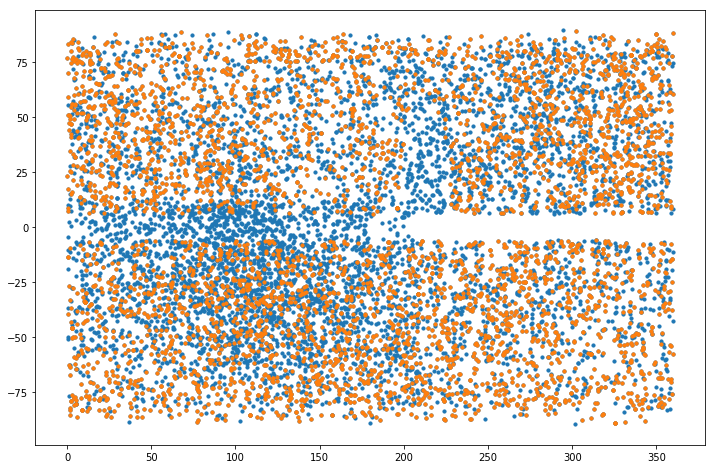

In [338]:
fig, ax = plt.subplots(1,1, figsize=[12, 8])
ax.scatter(dfw.loc[dfw.detected, 'ECLONG'], dfw.loc[dfw.detected, 'ECLAT'], s=10)
ax.scatter(dfw.loc[dfw.detected_primary, 'ECLONG'], dfw.loc[dfw.detected_primary, 'ECLAT'], s=10)

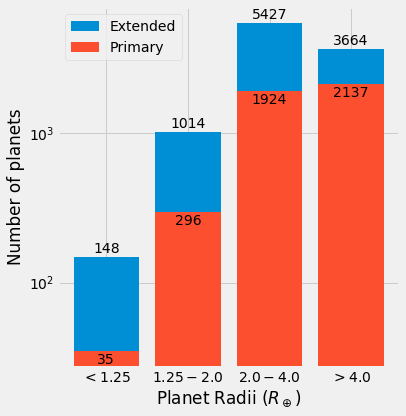

In [339]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height+(height*0.02),
                '%d' % int(height),
                ha='center', va='bottom')

def autolabel2(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height-(height*0.22),
                '%d' % int(height),
                ha='center', va='bottom')

counts = np.histogram(detected_DF.planetRadius, bins = [0,1.25,2,4,25])
counts2 = np.histogram(detected_2min.planetRadius, bins = [0,1.25,2,4,25])
tl = ['$<1.25$', '$1.25-2.0$', '$2.0-4.0$', '$>4.0$']
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1,1,figsize=[6,6])
    
    h1 = ax.bar(np.arange(4), counts[0], tick_label = tl, label='Extended')
    h2 = ax.bar(np.arange(4), counts2[0], tick_label = tl, label='Primary')
    ax.set_xlabel('Planet Radii ($ R_\oplus$)')
    ax.set_ylabel('Number of planets')
#     ax.set_xlim(0,6)
    fig.tight_layout()
    ax.set_yscale('log')
#     fig.savefig('../plots/obs_len.png', dpi=200)
    autolabel(h1)
    autolabel2(h2)
    ax.legend()


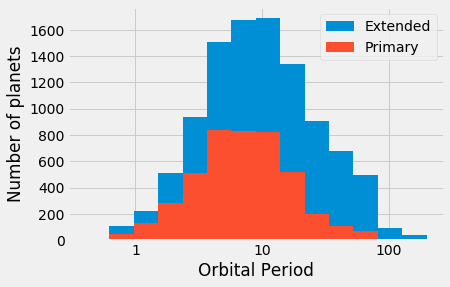

In [340]:
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1,1,)
    ax.set_xscale('log')
    ax.hist(detected_DF.planetPeriod, bins=np.logspace(np.log10(0.4),np.log10(200),15), label='Extended')
    ax.hist(detected_2min.planetPeriod, bins=np.logspace(np.log10(0.4),np.log10(200),15), label='Primary')
    from matplotlib.ticker import StrMethodFormatter, NullFormatter
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.legend()
    
    ax.set_xlabel('Orbital Period')
    ax.set_ylabel('Number of planets')

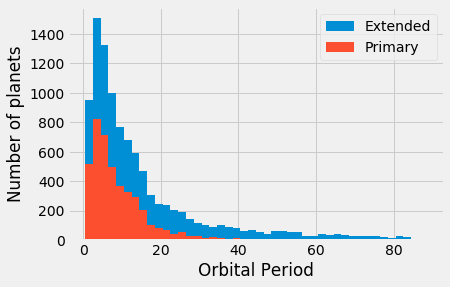

In [341]:
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1,1,)
#     ax.set_xscale('log')
    ax.hist(detected_DF.planetPeriod, bins=np.arange(0.5,90,2), label='Extended')
    ax.hist(detected_2min.planetPeriod, bins=np.arange(0.5,90,2), label='Primary')
#     ax.hist(detected_2min.planetPeriod, bins=np.logspace(np.log10(0.4),np.log10(200),15))
    ax.set_xlabel('Orbital Period')
    ax.set_ylabel('Number of planets')
    ax.legend()

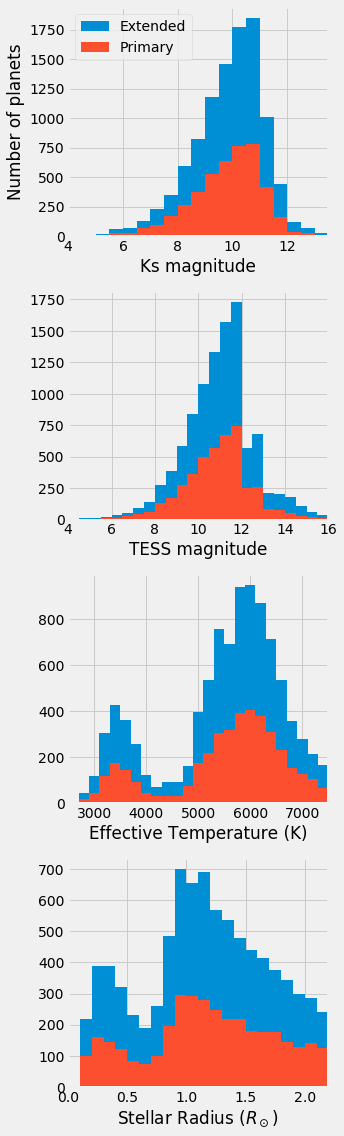

In [342]:
with plt.style.context('fivethirtyeight'):
    fig, [ax1,ax2,ax3,ax4] = plt.subplots(4,1,figsize=[5,16])
    
    h1 = ax1.hist(detected_DF.Ks, bins=np.arange(2,16.5,0.5), label='Extended')
    h1 = ax1.hist(detected_2min.Ks, bins=np.arange(2,16.5,0.5), label='Primary')
    ax1.set_xlabel('Ks magnitude')
    ax1.set_ylabel('Number of planets')
    ax1.set_xlim(4,13.5)
    ax1.legend()
    
    h2 = ax2.hist(detected_DF.TESSMAG, bins=np.arange(4,16.5,0.5))
    h2 = ax2.hist(detected_2min.TESSMAG, bins=np.arange(4,16.5,0.5))
    ax2.set_xlabel('TESS magnitude')
    ax2.set_xlim(4,16.0)
    
    h3 = ax3.hist(detected_DF.TEFF, bins=np.arange(2500,7500+250,200))
    h3 = ax3.hist(detected_2min.TEFF, bins=np.arange(2500,7500+250,200))
    ax3.set_xlabel('Effective Temperature (K)')
    ax3.set_xlim(2500,7500)
    
    h4 = ax4.hist(detected_DF.RADIUS, bins=np.arange(0,2.8,0.1))
    h4 = ax4.hist(detected_2min.RADIUS, bins=np.arange(0,2.8,0.1))
    ax4.set_xlabel('Stellar Radius ($R_\odot$)')
    ax4.set_xlim(0,2.2)
    
    fig.tight_layout()

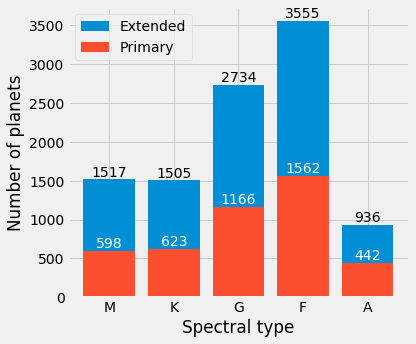

In [343]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height+1,
                '%d' % int(height),
                ha='center', va='bottom')

def autolabel2(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height-1,
                '%d' % int(height),
                ha='center', va='bottom', color='white')

counts = np.histogram(detected_DF.TEFF, bins = [2285,3905,5310,5980,7330.,10050])
counts2 = np.histogram(detected_2min.TEFF, bins = [2285,3905,5310,5980,7330.,10050])
tl = ['M', 'K', 'G', 'F', 'A']
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1,1,figsize=[6,5])
    
    h1 = ax.bar(np.arange(5), counts[0], tick_label = tl, label='Extended')
    h2 = ax.bar(np.arange(5), counts2[0], tick_label = tl, label='Primary')
    ax.set_xlabel('Spectral type')
    ax.set_ylabel('Number of planets')
#     ax.set_xlim(0,6)
    fig.tight_layout()
#     ax.set_yscale('log')
#     fig.savefig('../plots/obs_len.png', dpi=200)
    autolabel(h1)
    autolabel2(h2)
    ax.legend()

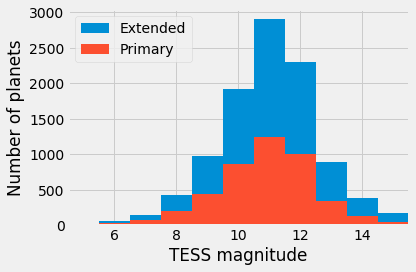

In [344]:
with plt.style.context('fivethirtyeight'):
    fig, ax1 = plt.subplots(1,1,figsize=[6,4])
    
    h1 = ax1.hist(detected_DF.TESSMAG, bins=np.arange(0.5,16.5,1), label='Extended')
    h1 = ax1.hist(detected_2min.TESSMAG, bins=np.arange(0.5,16.5,1), label='Primary')
    ax1.set_xlabel('TESS magnitude')
    ax1.set_ylabel('Number of planets')
    ax1.set_xlim(4.5,15.5)
    ax1.legend()
    
    
    fig.tight_layout()

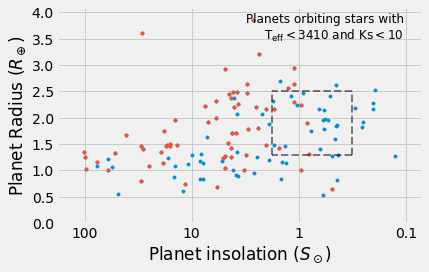

In [345]:
# later than M3
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1,1,figsize=[6,4])

    
    ax.scatter(get_insol(detected_DF[(detected_DF.TEFF < 3410) & (detected_DF.Ks < 10)].TEFF, 
                         detected_DF[(detected_DF.TEFF < 3410) & (detected_DF.Ks < 10)].ars), 
               detected_DF[(detected_DF.TEFF < 3410) & (detected_DF.Ks < 10)].planetRadius, s=11)
    ax.scatter(get_insol(detected_2min[(detected_2min.TEFF < 3410) & (detected_2min.Ks < 10)].TEFF, 
                         detected_2min[(detected_2min.TEFF < 3410) & (detected_2min.Ks < 10)].ars), 
               detected_2min[(detected_2min.TEFF < 3410) & (detected_2min.Ks < 10)].planetRadius, s=11)
    ax.set_ylim(0,4.1)
    ax.set_xscale("log",)
    ax.set_xlim(180,0.07)

    ax.set_ylabel('Planet Radius ($R_\oplus$)')
    ax.set_xlabel('Planet insolation ($S_\odot$)')
    ax.xaxis.set_ticklabels(['','','0.1','1','10', '100'])
    
    ax.vlines(0.32,1.3,2.5, linestyles='--', alpha=0.5, lw=2)
    ax.vlines(1.78,1.3,2.5, linestyles='--', alpha=0.5, lw=2)
    ax.hlines(2.5,0.32,1.78,linestyles='--', alpha=0.5, lw=2)
    ax.hlines(1.3,0.32,1.78,linestyles='--', alpha=0.5, lw=2)
    ax.text(0.95, 0.9,'Planets orbiting stars with\n$\mathrm{T_{eff}}<$3410 and Ks$<$10', horizontalalignment='right',
        verticalalignment='center',
        transform=ax.transAxes, fontsize=12)

    fig.tight_layout()

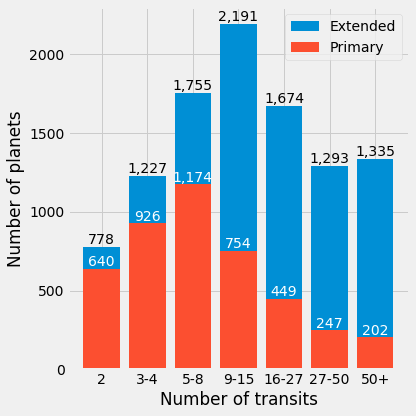

In [354]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height+(0),
                "{:,}".format(int(height)),
                ha='center', va='bottom')

def autolabel2(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height+(0),
                "{:,}".format(int(height)),
                ha='center', va='bottom', color='white')

counts = np.histogram(detected_DF['Ntransits'], bins = [0.5,2.5,4.5, 8.5,15.5,27.5, 50, 10000])
counts2 = np.histogram(detected_2min['Ntransits_primary'], bins = [0.5,2.5,4.5, 8.5,15.5,27.5, 50, 10000])
# tl = ['$<1.25$', '$1.25 - 2.0$', '$2.0 - 4.0$', '$>4.0$']
tl = ['2', '3-4', '5-8', '9-15', '16-27', '27-50', '50+']
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1,1,figsize=[6,6])
    
    h1 = ax.bar(np.arange(7), counts[0], tick_label = tl, label='Extended')
    h2 = ax.bar(np.arange(7), counts2[0], tick_label = tl, label='Primary')
    ax.set_xlabel('Number of transits')
    ax.set_ylabel('Number of planets')
#     ax.set_yscale('log')
#     ax.set_xlim(0,6)
    fig.tight_layout()
#     fig.savefig('../plots/obs_len.png', dpi=200)
    autolabel(h1)
    autolabel2(h2)
    ax.legend()